In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tenpy
import tenpy.linalg.np_conserved as npc
tenpy.show_config()

from tenpy.networks.site import SpinSite
from tenpy.models.lattice import Lattice, IrregularLattice
from tenpy.models.model import CouplingModel,MPOModel
import tenpy.models.lattice as lattice

from tenpy.networks.mps import MPS
from tenpy.algorithms import tebd, dmrg, tdvp
from tenpy.algorithms.dmrg import TwoSiteDMRGEngine


import time

tenpy 0.10.0.dev0+unknown (not compiled),
git revision unknown using
python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
numpy 1.21.5, scipy 1.7.3


C:\Users\Asus\TeNPy\tenpy\tools\optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [2]:
class IsingZZX():
    
    
    def __init__(self,ising_params):
        
        ''' PARAMETERS ''' 
        
        self.L,n_vect,self.B,self.J=ising_params['L'],ising_params['n_vect'],ising_params['B'],ising_params['J']
        
        if len(n_vect)==3:
            self.B_vect=n_vect/np.linalg.norm(n_vect)*self.B    # Cartesian
            
        elif len(n_vect)==2:                                    # Spherical
            self.B_vect=self.B*np.array([np.sin(n_vect[1])*np.cos(n_vect[0]),np.sin(n_vect[1])*np.sin(n_vect[0]),np.cos(n_vect[1])])
            
        else:
            return
        
        ''' SITES '''
        
        self.sp = SpinSite(S=ising_params['S_max'],conserve=None,sort_charge=True)
        
        
        ''' LATTICE '''
        
        self.lat=Lattice([self.L],unit_cell=[self.sp],bc_MPS=ising_params['bc_mps'],bc=ising_params['bc'])
        
        ''' ORDERING ''' 
        
        '''We set the order in which the MPS/MPO traverses the lattice sites. 
        This makes more sense for 2D lattices or 1D irregular lattices, but we can do it describing a line 0-1-2-3-4,... or combining 
        both 1 and 2 site jumps 0-2-1-3-4-6-5-7-... to make it more compatible with next-nearest neighbors couplings.
        
        '''
       
        '''order=[]
        for i in range(0,self.L//4):
            order+=[[4*i,0],[4*i+2,0],[4*i+1,0],[4*i+3,0]]
        order+=[[self.L-i-1,0] for i in reversed(range(self.L%4))]       # 0-2-1-3-5-4  Didn't finally work so well :(

        self.lat.order=np.array(order).reshape(self.L,2)'''
        
        self.lat.order=np.array([[i,0] for i in range(self.L)]).reshape(self.L,2) # 0-1-2-3-4-...
        ''' COUPLINGS '''
        
        self.Cm=CouplingModel(self.lat)
        
        
        for i in range(self.L-2):
            self.Cm.add_local_term(-self.J[0],[('Sz',[i,0]),('Sz',[i+1,0])])
            self.Cm.add_local_term(-self.J[1],[('Sz',[i,0]),('Sz',[i+2,0])])
            
        if ising_params['bc']=='periodic':
            self.Cm.add_local_term(-self.J[0],[('Sz',[self.L,0]),('Sz',[0,0])])
            self.Cm.add_local_term(-self.J[1],[('Sz',[self.L-1,0]),('Sz',[0,0])])
            self.Cm.add_local_term(-self.J[1],[('Sz',[self.L,0]),('Sz',[1,0])])
            
        for i in range(self.L):
            for j,beta in enumerate(['x','y','z']):
                self.Cm.add_local_term(-self.B_vect[j],[('S'+beta,[i,0])])
        
        ''' MPO CALCULATION '''
        
        self.H_MPO=self.Cm.calc_H_MPO(tol_zero=1e-10)         
        
        
        ''' LATTICE PLOT '''
        self.lat.pairs['nearest_neighbors']= [(0,0,np.array([1]))]
        self.lat.pairs['next_nearest_neighbors']= [(0,0,np.array([2]))]
        
        if ising_params['plot_lattice']:
            plt.figure(figsize=(20,10))
            ax = plt.gca()
            ax.set_title('$1D\;Spin\;Chain\;(s=%.1f)$'%ising_params['S_max'])
            self.lat.plot_coupling(ax,coupling=self.lat.pairs['nearest_neighbors'],lw=2)
            self.lat.plot_order(ax, linestyle=':',color='r',lw=2)
            self.lat.plot_sites(ax)
            self.lat.plot_basis(ax, origin=(-1,-1))
            ax.set_aspect('equal')
            ax.set_xlim(-2,self.L+1)
            ax.set_ylim(-2,2)
            
    
    def initial_state(self,mode,show_pstate=False):
        '''
        Set the initial wavefunction in all lattice. 3 modes:
        
        (int): mode=[0,1,2,...,D], where D is the site dimension. Initializes all sites in the same local state
        
        (list)(random mode): mode=[n0,n1,...,ni,...,nD], where ni is the where n_i reflects the proportion of times 
                             that state i appears in the initial state. For instance, mode=[1,2,3] means that the 
                             frequency of appearance is roughly [1/6,2/6,3/6]
           
        '''
        
        if type(mode)==int:
            
            a=[0]*self.sp.dim
            a[mode]=1
            p=[a for i in range(self.L)]
            
        
        if type(mode)==list:
            D=len(mode)
            mode/=np.sum(mode)

            intervals=[[0,mode[0]]]
            aux=0
            for i in range(D-1):
                aux+=mode[i]
                intervals+=[ [aux,aux+mode[i+1]] ]
                
            p=[]
            for ran in np.random.rand(self.L):
                pp=[0]*D
                for i in range(D):
                    if(ran>intervals[i][0] and ran<intervals[i][1]):
                        pp[i]=1
                        break
                p+=[pp]

            ini=time.time()
            fin=0
            while(fin<ini+0.5):
                np.random.permutation(p)
                fin=time.time()
        
        if mode=='Neel':
            p=[[1,0],[0,1]]*(self.L//2)
            if(self.L%2!=0):
                p+=[[1,0]]
        
        
        if show_pstate:
            print('Initial State has been generated\n')
            print('p_state: ',p,'\n\n')
        
        return MPS.from_product_state(self.lat.mps_sites(),p,bc=self.lat.bc_MPS,permute=False)

# MAIN

### Parameters

In [16]:
ising_params={
              'L':100,                          # 1D Chain lenght (number of spins)
              'S_max':0.5,                     # +-1/2 as default 
              'n_vect': [1,0,0],               # Direction of the magnetic field in the sphere (X as default).
                                               # Can be set in 3 cartesian coordinates [x,y,z] or in 2 spherical coordinates [theta,phi].
                                                 
              'B':0.5,                         # Magnetic field module
                                               
              'J':[0,0.5],                     # [J_NN , J_nNN] hoppings for Nearest Neighbors and next-Nearest Neighbors.
                                               # We set J_NN=0 as required. Use both to build an ANNNI spin model
    
              'bc_mps':'finite',               # MPS boundary conditions ('finite','infinite'). We would change it for the last task 
              'bc':'open',                     # Lattice boundary conditions ('open','periodic')
              'plot_lattice': False
}

DMRG_options={

    'mixer': True,
    'min_sweeps':5,
    'max_sweeps':100,
    'chi_list':{0:50,20:100,50:200},
    'trunc_params': {'chi_max': 100,
                    'svd_min': 1.e-10},
    'max_E_err': 1.e-10
}


IM=IsingZZX(ising_params)

In [ ]:
### Intialize an MPS

In [17]:
mode=[1,1]              # It can be 0, 1, tuple or 'Neel' (str)   

psi0=IM.initial_state(mode='Neel')#,show_pstate=true)

# DMRG

In [18]:
B_values=np.arange(0,0.5,0.01)
J_values=[0.5,0.75,1.0]

E_gr=[[] for i in J_values]
X=[[] for i in J_values]

''' Initial State'''
psi0=IM.initial_state(mode='Neel')


for j,J in enumerate(J_values):
    print('J=%.2f'%J)
    ising_params['J']=[0,J]
    psi_gr=psi0.copy()
    for i,B in enumerate(B_values):
        ising_params['B']=B
        IM=IsingZZX(ising_params)                  #Reload the model for each field value

        '''GR. STATE'''

        eng=TwoSiteDMRGEngine(psi_gr,IM,DMRG_options) 
        E_run,psi_gr=eng.run()

        E_gr[j].append(E_run)
        X[j].append(np.sum(np.abs(psi_gr.expectation_value('Sz')))/psi_gr.L/B)
        print('    B: %.2f \t\t E: %.2f \t\t X: %.2f '%(B,E_gr[j][i],X[j][i]))
        #print(psi_gr.expectation_value('Sz'))


J=0.50


C:\Users\Asus\AppData\Local\Temp\ipykernel_13056\2650938582.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  M[j].append(np.sum(np.abs(psi_gr.expectation_value('Sz')))/psi_gr.L/B)


    B: 0.00 		 E: -12.25 		 X: inf 
[-0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5]
    B: 0.01 		 E: -12.26 		 X: 49.99 
[-0.49959984  0.49959984 -0.49989958  0.49989958 -0.49989993  0.49989993
 -0.49989993  0.49989993 -0.49989993  0.49989993 -0.49989993  0.49989993
 -0.49989993  0.49989993 -0.49989993  0.49989993 -0.49989993  0.49989993
 -0.49989993  0.49989993 -0.49989993  0.49989993 -0.49989993  0.49989993
 -0.49989993  0.49989993 -0.49989993  0.49989993 -0.49989993  0.49989993
 -0.49989993  0.49989993 -0.49989993  0.49989993 -0.

C:\Users\Asus\TeNPy\tenpy\tools\params.py:237: UserWarning: unused options for config TwoSiteDMRGEngine:
['norm_tol', 'norm_tol_final']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


    B: 0.07 		 E: -12.51 		 X: 7.06 
[-0.48        0.48       -0.49406567  0.49406567 -0.49486759  0.49486759
 -0.4949194   0.4949194  -0.49492293  0.49492293 -0.49492318  0.49492318
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  -0.4949232   0.4949232  -0.4949232   0.4949232
 -0.4949232   0.4949232  

    B: 0.14 		 E: -13.29 		 X: 3.38 
[-0.4142463   0.4142463  -0.46231184  0.46231184 -0.47317302  0.47317302
 -0.47596648  0.47596648 -0.47672648  0.47672648 -0.47693986  0.47693986
 -0.47700097  0.47700097 -0.47701872  0.47701872 -0.47702393  0.47702393
 -0.47702547  0.47702547 -0.47702593  0.47702593 -0.47702607  0.47702607
 -0.47702611  0.47702611 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702612  0.47702612 -0.47702612  0.47702612
 -0.47702612  0.47702612 -0.47702611  0.47702611 -0.47702607  0.47702607
 -0.47702593  

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=3.62e-04


    B: 0.19 		 E: -14.21 		 X: 1.28 
[-0.17957658  0.18137813 -0.21749851  0.2196805  -0.23308373  0.23542207
 -0.24040761  0.24281943 -0.24405833  0.24650678 -0.245939    0.24840632
 -0.24692854  0.24940583 -0.24745682  0.24993941 -0.24774185  0.25022732
 -0.24789692  0.25038394 -0.24798182  0.25046968 -0.24802855  0.25051687
 -0.24805439  0.25054296 -0.24806873  0.25055742 -0.24807671  0.25056547
 -0.24808117  0.25056996 -0.24808367  0.25057247 -0.24808506  0.25057388
 -0.24808584  0.25057467 -0.24808627  0.25057511 -0.24808651  0.25057536
 -0.24808664  0.25057549 -0.24808672  0.25057557 -0.24808677  0.25057561
 -0.24808678  0.25057563 -0.24808678  0.25057563 -0.24808676  0.2505756
 -0.24808673  0.25057557 -0.24808664  0.25057549 -0.2480865   0.25057535
 -0.24808626  0.25057511 -0.24808582  0.25057466 -0.24808503  0.25057387
 -0.24808364  0.25057247 -0.24808116  0.25056996 -0.24807671  0.25056547
 -0.24806875  0.25055743 -0.24805444  0.25054297 -0.24802863  0.25051689
 -0.24798193  0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=5.20e-05


    B: 0.20 		 E: -14.44 		 X: 0.01 
[-0.00104983  0.00106494 -0.00129476  0.0013134  -0.00140591  0.00142615
 -0.00146366  0.00148471 -0.00149549  0.00151702 -0.00151358  0.00153544
 -0.00152416  0.00154617 -0.00153043  0.00155251 -0.00153419  0.0015563
 -0.00153645  0.00155858 -0.00153783  0.00155996 -0.00153867  0.00156081
 -0.00153918  0.00156132 -0.0015395   0.00156164 -0.00153969  0.00156184
 -0.00153982  0.00156196 -0.00153989  0.00156203 -0.00153994  0.00156208
 -0.00153997  0.00156211 -0.00153998  0.00156213 -0.00153999  0.00156214
 -0.00154     0.00156214 -0.00154     0.00156215 -0.00154001  0.00156215
 -0.00154001  0.00156215 -0.00154001  0.00156215 -0.00154001  0.00156215
 -0.00154001  0.00156215 -0.00154     0.00156214 -0.00153999  0.00156214
 -0.00153998  0.00156213 -0.00153997  0.00156211 -0.00153994  0.00156208
 -0.00153989  0.00156203 -0.00153982  0.00156196 -0.0015397   0.00156184
 -0.00153951  0.00156164 -0.00153919  0.00156132 -0.00153869  0.00156081
 -0.00153785  0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.06e-05


    B: 0.21 		 E: -14.68 		 X: 0.01 
[-0.00063523  0.0010152  -0.00079811  0.00127551 -0.00087931  0.00140527
 -0.00092561  0.00147926 -0.00095381  0.00152434 -0.00097152  0.00155266
 -0.00098289  0.00157083 -0.00099028  0.00158265 -0.00099515  0.00159044
 -0.00099838  0.0015956  -0.00100054  0.00159905 -0.00100199  0.00160137
 -0.00100296  0.00160293 -0.00100363  0.00160399 -0.00100408  0.00160471
 -0.00100438  0.0016052  -0.00100459  0.00160554 -0.00100474  0.00160577
 -0.00100484  0.00160593 -0.00100491  0.00160603 -0.00100496  0.00160611
 -0.00100499  0.00160616 -0.00100501  0.00160619 -0.00100502  0.00160621
 -0.00100503  0.00160622 -0.00100503  0.00160622 -0.00100503  0.00160621
 -0.00100502  0.00160619 -0.001005    0.00160616 -0.00100497  0.00160611
 -0.00100492  0.00160604 -0.00100485  0.00160593 -0.00100476  0.00160578
 -0.00100461  0.00160555 -0.0010044   0.00160522 -0.0010041   0.00160473
 -0.00100365  0.00160401 -0.00100299  0.00160296 -0.00100201  0.0016014
 -0.00100057  0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.02e-05


    B: 0.22 		 E: -14.93 		 X: 0.00 
[-0.00030117  0.00038426 -0.00038565  0.00049204 -0.00043167  0.00055076
 -0.00046026  0.00058721 -0.00047954  0.00061185 -0.00049285  0.00062887
 -0.00050221  0.00064085 -0.00050889  0.0006494  -0.00051371  0.00065556
 -0.00051721  0.00066005 -0.00051977  0.00066333 -0.00052165  0.00066574
 -0.00052303  0.00066752 -0.00052405  0.00066883 -0.00052481  0.00066979
 -0.00052536  0.00067051 -0.00052578  0.00067104 -0.00052608  0.00067144
 -0.00052631  0.00067173 -0.00052648  0.00067195 -0.00052661  0.00067211
 -0.0005267   0.00067222 -0.00052676  0.0006723  -0.0005268   0.00067235
 -0.00052682  0.00067238 -0.00052682  0.00067238 -0.00052681  0.00067236
 -0.00052677  0.00067231 -0.00052672  0.00067223 -0.00052663  0.00067212
 -0.00052651  0.00067196 -0.00052634  0.00067174 -0.00052612  0.00067145
 -0.00052581  0.00067105 -0.0005254   0.00067052 -0.00052484  0.00066981
 -0.0005241   0.00066886 -0.0005231   0.00066757 -0.00052174  0.00066583
 -0.00051989  

    B: 0.28 		 E: -16.90 		 X: 0.00 
[1.46012646e-11 1.58950630e-12 2.10723661e-11 2.29607999e-12
 2.65570899e-11 2.90117930e-12 2.35031319e-11 3.19177759e-12
 5.27714780e-11 4.33641894e-12 8.22371310e-11 5.36437835e-12
 8.71374428e-11 6.64414398e-12 7.47597813e-11 7.89191283e-12
 4.79093241e-11 9.11833743e-12 4.99130942e-11 1.03395324e-11
 4.40414027e-11 1.15715210e-11 2.69820325e-11 1.28752203e-11
 2.16273670e-11 1.42635081e-11 5.31617835e-11 1.55598236e-11
 1.01232251e-10 1.71954066e-11 1.39270474e-10 1.91193451e-11
 1.60908897e-10 2.12236967e-11 1.69359492e-10 2.34579692e-11
 1.68990358e-10 2.58367429e-11 1.63217715e-10 2.83583016e-11
 1.54286618e-10 3.10874212e-11 1.43706281e-10 3.40474791e-11
 1.32423104e-10 3.72828502e-11 1.21059618e-10 4.08032795e-11
 1.09988333e-10 4.46539278e-11 9.94466103e-11 4.88319872e-11
 8.95982109e-11 5.33537638e-11 8.04953669e-11 5.81697662e-11
 7.21648422e-11 6.32128537e-11 6.46214574e-11 6.84052577e-11
 5.77930548e-11 7.36257778e-11 5.16583194e-11 7.

    B: 0.33 		 E: -18.91 		 X: 0.00 
[ 1.63757896e-14 -2.54518628e-14  1.11299858e-14 -8.26838598e-14
 -1.21264110e-13  5.30964162e-14 -1.51974820e-13  6.06890591e-14
 -1.34568961e-13  6.05908372e-14 -1.29223969e-13  8.87167502e-14
 -1.49690069e-13  9.43620067e-14 -1.64292098e-13  9.02362217e-14
 -1.64319919e-13  9.26716130e-14 -1.54770303e-13  9.49154261e-14
 -1.44040023e-13  9.05675388e-14 -1.27551250e-13  8.18374289e-14
 -9.14797947e-14  6.09383742e-14 -5.48682724e-14  4.98909644e-14
 -3.92743748e-14  4.03001162e-14 -3.85727728e-14  2.40562537e-14
 -6.27211851e-14  2.07443053e-14 -9.17708789e-14  1.31387384e-14
 -8.95483158e-14  2.29534557e-15 -7.00092295e-14  4.97478205e-16
 -4.23424949e-14 -4.08194808e-15 -2.90146188e-15 -1.33790924e-14
  2.28043410e-14 -2.03673967e-14  3.00200186e-14 -2.83493913e-14
  7.65801829e-15 -4.45546998e-14 -3.36518468e-14 -6.53015482e-14
 -6.84387535e-14 -7.39484368e-14 -8.92814130e-14 -9.09180129e-14
 -1.01735091e-13 -7.61812522e-14 -1.04067036e-13 -7.5

    B: 0.38 		 E: -21.07 		 X: 0.00 
[-3.41393580e-15 -2.81163981e-14 -1.72084569e-14 -3.01980663e-14
 -6.49758025e-14 -2.04003481e-14 -9.31144305e-14 -1.98841672e-14
 -9.72455933e-14 -3.24546654e-14 -1.19941877e-13 -8.35914252e-14
 -1.18963600e-13 -1.06901629e-13 -1.52583189e-13 -9.01943778e-14
 -1.83385036e-13 -3.86475198e-14 -1.38337995e-13 -2.13193304e-15
 -9.45054344e-14 -1.18339694e-14 -9.01231361e-14 -4.17921128e-14
 -6.83408745e-14 -7.19050893e-14 -8.41593349e-14 -1.09162541e-13
 -1.52554954e-13 -1.68907205e-13 -1.96883241e-13 -1.78638257e-13
 -2.27914604e-13 -1.11084780e-13 -2.18434251e-13 -6.52903030e-14
 -1.52425130e-13 -7.76762520e-14 -8.92847855e-14 -1.32014611e-13
 -5.01247500e-14 -1.84709615e-13 -3.11222499e-14 -2.03544605e-13
 -5.09366957e-14 -1.79252849e-13 -6.59206726e-14 -1.42873562e-13
 -6.04761688e-14 -9.76403155e-14 -4.73970812e-14 -7.06289213e-14
 -1.88144173e-14 -8.20917899e-14  1.57475111e-14 -1.13648031e-13
  4.79908343e-14 -1.13560987e-13  5.55057767e-14 -1.0

    B: 0.43 		 E: -23.32 		 X: 0.00 
[ 1.50990331e-14  6.55031585e-15 -8.24340596e-15  1.88182803e-14
 -4.08006962e-15  1.18072219e-13 -4.58207049e-15  1.01307221e-13
 -3.54434922e-14  5.44077213e-14 -4.97779403e-14  1.24915755e-14
 -6.03143334e-14 -5.51319829e-14 -3.35137828e-14 -1.05724627e-13
  2.55344010e-14 -8.57099964e-14  7.92874174e-14 -6.43894705e-14
  1.45104915e-13 -4.52974154e-14  1.84922692e-13 -4.79030746e-14
  2.64483295e-13 -5.89767934e-14  3.01106256e-13 -7.51479807e-14
  2.70222536e-13 -8.42988035e-14  1.00894483e-13 -3.38227338e-14
 -7.42906355e-14  3.44018860e-14 -7.19276309e-14  4.03373590e-14
 -6.81069484e-14  3.33467355e-14 -6.52716751e-14  1.68140442e-14
 -2.63722079e-14 -3.18609586e-14  1.29554080e-14 -5.39135062e-14
  2.11854328e-14 -2.77892901e-14 -2.20061448e-14 -1.73946607e-15
 -4.43722073e-14  1.45111114e-14 -4.76470897e-14  2.90441808e-14
 -5.63885506e-14  4.04241262e-14 -5.35300730e-14  1.54054898e-14
 -5.44555474e-14 -4.19506987e-15 -8.52001934e-14 -3.6

    B: 0.48 		 E: -25.62 		 X: 0.00 
[-1.03250741e-14 -1.12687637e-14 -1.49602553e-14 -1.97064587e-14
 -8.64863736e-14  3.60822483e-14 -6.57249718e-14  1.60183357e-14
 -1.81267130e-14  1.70146285e-14 -2.05353572e-14  2.10737985e-14
 -5.29872949e-14  2.42987732e-14 -7.40801689e-14  2.72815716e-14
 -4.88490643e-14  3.09225418e-14 -1.45945374e-14  2.84254590e-14
 -1.68003566e-14  2.03711265e-14 -1.21321426e-14  3.05345172e-14
 -1.51695240e-14  2.86470488e-14 -2.42658990e-14  1.23285033e-14
 -3.82195630e-14 -9.76232333e-15 -5.79378242e-14 -3.34622557e-14
 -7.26218974e-14 -3.12469443e-14 -6.96572884e-14 -7.08362083e-15
 -1.74743470e-14  1.97701195e-14  1.63335826e-14  1.83951400e-14
  1.18864743e-14  1.92258048e-14  4.02464557e-15  1.46033347e-14
  1.94273929e-14  4.01616715e-14  3.68775687e-14  5.58533151e-14
  3.40358508e-14  2.37659774e-14 -5.51095107e-15  1.23297509e-14
 -7.95089038e-14 -4.48825576e-14 -1.20096804e-13 -8.76631460e-14
 -4.92124336e-14 -7.55077734e-14 -4.74323755e-15 -1.8

C:\Users\Asus\AppData\Local\Temp\ipykernel_13056\2650938582.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  M[j].append(np.sum(np.abs(psi_gr.expectation_value('Sz')))/psi_gr.L/B)


    B: 0.00 		 E: -18.38 		 X: inf 
[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5]
    B: 0.01 		 E: -18.38 		 X: 50.00 
[-0.49982219 -0.49982219 -0.49995547 -0.49995547 -0.49995554 -0.49995554
 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554
 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554
 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554
 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.49995554
 -0.49995554 -0.49995554 -0.49995554 -0.49995554 -0.

    B: 0.08 		 E: -18.60 		 X: 6.21 
[-0.48848974 -0.48848974 -0.49681077 -0.49681077 -0.49708648 -0.49708648
 -0.49709683 -0.49709683 -0.49709724 -0.49709724 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725 -0.49709725
 -0.49709725 -

    B: 0.15 		 E: -19.16 		 X: 3.25 
[-0.45825757 -0.45825757 -0.48556783 -0.48556783 -0.48873595 -0.48873595
 -0.48915304 -0.48915304 -0.48921105 -0.48921105 -0.48921937 -0.48921937
 -0.48922059 -0.48922059 -0.48922077 -0.48922077 -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  

    B: 0.22 		 E: -20.09 		 X: 2.14 
[-0.40491426 -0.40491426 -0.45640845 -0.45640845 -0.46916205 -0.46916205
 -0.47275933 -0.47275933 -0.47383296 -0.47383296 -0.47416367 -0.47416367
 -0.4742676  -0.4742676  -0.47430073 -0.47430073 -0.4743114  -0.4743114
 -0.47431486 -0.47431486 -0.47431599 -0.47431599 -0.47431636 -0.47431636
 -0.47431648 -0.47431648 -0.47431652 -0.47431652 -0.47431653 -0.47431653
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431654
 -0.47431654 -0.47431654 -0.47431654 -0.47431654 -0.47431653 -0.47431653
 -0.47431652 -0.47431652 -0.47431648 -0.47431648 -0.47431636 -0.47431636
 -0.47431599 -0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.58e-04


    B: 0.28 		 E: -21.21 		 X: 1.00 
[-0.21140067 -0.21116563 -0.25453054 -0.25424755 -0.27165774 -0.2713557
 -0.2794321  -0.27912142 -0.28317447 -0.28285964 -0.2850361  -0.28471919
 -0.2859818  -0.28566382 -0.28646921 -0.28615069 -0.2867231  -0.2864043
 -0.28685643 -0.28653749 -0.28692689 -0.28660788 -0.28696432 -0.28664527
 -0.28698429 -0.2866652  -0.28699498 -0.28667588 -0.28700072 -0.28668162
 -0.28700381 -0.28668471 -0.28700547 -0.28668638 -0.28700638 -0.28668728
 -0.28700687 -0.28668776 -0.28700713 -0.28668803 -0.28700728 -0.28668817
 -0.28700735 -0.28668825 -0.28700739 -0.28668829 -0.28700742 -0.28668831
 -0.28700742 -0.28668832 -0.28700742 -0.28668832 -0.28700741 -0.28668831
 -0.28700739 -0.2866883  -0.28700735 -0.28668825 -0.28700727 -0.28668818
 -0.28700713 -0.28668803 -0.28700687 -0.28668776 -0.28700638 -0.28668729
 -0.28700548 -0.28668637 -0.28700381 -0.28668471 -0.28700072 -0.28668163
 -0.28699498 -0.28667589 -0.28698429 -0.28666521 -0.28696432 -0.28664527
 -0.2869269  -0.

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.02e-05


    B: 0.31 		 E: -21.89 		 X: 0.01 
[-0.00124588 -0.00139228 -0.00155562 -0.00173841 -0.00170535 -0.00190573
 -0.00178817 -0.00199829 -0.00183698 -0.00205283 -0.00186667 -0.00208602
 -0.00188513 -0.00210665 -0.00189677 -0.00211966 -0.00190419 -0.00212795
 -0.00190896 -0.00213328 -0.00191205 -0.00213674 -0.00191406 -0.00213898
 -0.00191537 -0.00214045 -0.00191624 -0.00214141 -0.0019168  -0.00214204
 -0.00191718 -0.00214246 -0.00191742 -0.00214274 -0.00191759 -0.00214292
 -0.0019177  -0.00214304 -0.00191777 -0.00214312 -0.00191782 -0.00214317
 -0.00191785 -0.00214321 -0.00191787 -0.00214323 -0.00191788 -0.00214324
 -0.00191788 -0.00214325 -0.00191788 -0.00214325 -0.00191788 -0.00214324
 -0.00191787 -0.00214323 -0.00191785 -0.00214321 -0.00191782 -0.00214317
 -0.00191777 -0.00214312 -0.0019177  -0.00214304 -0.00191759 -0.00214292
 -0.00191743 -0.00214274 -0.00191718 -0.00214246 -0.00191681 -0.00214205
 -0.00191624 -0.00214142 -0.00191538 -0.00214046 -0.00191407 -0.00213899
 -0.00191207 -

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.14e-05


    B: 0.32 		 E: -22.14 		 X: 0.00 
[-0.00080005 -0.00086478 -0.00101153 -0.00109338 -0.00112017 -0.00121081
 -0.00118397 -0.00127977 -0.00122417 -0.00132323 -0.00125024 -0.00135142
 -0.0012675  -0.00137008 -0.00127909 -0.00138261 -0.00128696 -0.00139112
 -0.00129235 -0.00139695 -0.00129607 -0.00140097 -0.00129864 -0.00140375
 -0.00130043 -0.00140569 -0.00130168 -0.00140704 -0.00130255 -0.00140798
 -0.00130317 -0.00140865 -0.0013036  -0.00140911 -0.00130391 -0.00140944
 -0.00130412 -0.00140967 -0.00130427 -0.00140983 -0.00130438 -0.00140995
 -0.00130445 -0.00141002 -0.0013045  -0.00141007 -0.00130453 -0.00141011
 -0.00130454 -0.00141012 -0.00130454 -0.00141012 -0.00130453 -0.00141011
 -0.0013045  -0.00141007 -0.00130446 -0.00141002 -0.00130438 -0.00140995
 -0.00130428 -0.00140983 -0.00130413 -0.00140967 -0.00130392 -0.00140944
 -0.00130362 -0.00140912 -0.00130319 -0.00140865 -0.00130258 -0.00140799
 -0.00130171 -0.00140705 -0.00130046 -0.0014057  -0.00129869 -0.00140378
 -0.00129613 -

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.65e-05


    B: 0.33 		 E: -22.40 		 X: 0.00 
[-0.00038072 -0.00040091 -0.00048751 -0.00051336 -0.00054568 -0.00057462
 -0.0005818  -0.00061263 -0.00060621 -0.00063836 -0.00062306 -0.00065613
 -0.00063493 -0.00066864 -0.0006434  -0.00067757 -0.0006495  -0.00068401
 -0.00065395 -0.00068869 -0.00065719 -0.00069212 -0.00065958 -0.00069464
 -0.00066133 -0.00069649 -0.00066263 -0.00069786 -0.0006636  -0.00069888
 -0.00066431 -0.00069963 -0.00066484 -0.00070018 -0.00066524 -0.0007006
 -0.00066553 -0.00070091 -0.00066575 -0.00070114 -0.00066592 -0.00070131
 -0.00066604 -0.00070143 -0.00066612 -0.00070151 -0.00066617 -0.00070157
 -0.0006662  -0.0007016  -0.00066621 -0.0007016  -0.00066619 -0.00070157
 -0.00066614 -0.00070152 -0.00066606 -0.00070144 -0.00066595 -0.00070132
 -0.00066579 -0.00070115 -0.00066558 -0.00070092 -0.00066528 -0.00070061
 -0.00066489 -0.00070019 -0.00066436 -0.00069963 -0.00066365 -0.00069889
 -0.0006627  -0.00069789 -0.00066143 -0.00069654 -0.0006597  -0.00069472
 -0.00065736 -0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.37e-05


    B: 0.34 		 E: -22.67 		 X: 0.00 
[-0.0001933  -0.00019324 -0.00025072 -0.00025064 -0.00028383 -0.00028373
 -0.00030556 -0.00030546 -0.00032117 -0.00032106 -0.00033257 -0.00033247
 -0.00034108 -0.00034098 -0.00034752 -0.00034742 -0.00035244 -0.00035234
 -0.00035622 -0.00035612 -0.00035915 -0.00035905 -0.00036142 -0.00036131
 -0.00036317 -0.00036305 -0.00036452 -0.0003644  -0.00036555 -0.00036543
 -0.00036634 -0.00036621 -0.00036694 -0.00036681 -0.00036739 -0.00036725
 -0.00036771 -0.00036758 -0.00036795 -0.00036781 -0.00036812 -0.00036798
 -0.00036824 -0.0003681  -0.00036831 -0.00036817 -0.00036835 -0.00036822
 -0.00036837 -0.00036824 -0.00036837 -0.00036823 -0.00036835 -0.00036821
 -0.0003683  -0.00036817 -0.00036822 -0.00036809 -0.00036811 -0.00036798
 -0.00036795 -0.00036782 -0.00036772 -0.0003676  -0.00036741 -0.00036728
 -0.00036698 -0.00036686 -0.0003664  -0.00036628 -0.00036564 -0.00036551
 -0.00036463 -0.0003645  -0.00036331 -0.00036318 -0.0003616  -0.00036147
 -0.00035938 -

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.08e-05


    B: 0.35 		 E: -22.96 		 X: 0.00 
[-3.33462687e-05 -3.47214211e-05 -4.38175624e-05 -4.56245361e-05
 -5.01937418e-05 -5.22636622e-05 -5.44966938e-05 -5.67351025e-05
 -5.80254476e-05 -6.04203600e-05 -6.07694127e-05 -6.32983377e-05
 -6.29568566e-05 -6.55889799e-05 -6.47178748e-05 -6.74292994e-05
 -6.61468408e-05 -6.89199221e-05 -6.73141142e-05 -7.01356310e-05
 -6.82726602e-05 -7.11325116e-05 -6.90627738e-05 -7.19531068e-05
 -6.97154117e-05 -7.26300241e-05 -7.02545340e-05 -7.31884528e-05
 -7.06987868e-05 -7.36479593e-05 -7.10627628e-05 -7.40238395e-05
 -7.13580566e-05 -7.43282866e-05 -7.15943271e-05 -7.45715056e-05
 -7.17802327e-05 -7.47626556e-05 -7.19239315e-05 -7.49103290e-05
 -7.20330027e-05 -7.50224333e-05 -7.21140292e-05 -7.51057492e-05
 -7.21722516e-05 -7.51655961e-05 -7.22114800e-05 -7.52057799e-05
 -7.22341921e-05 -7.52287190e-05 -7.22416705e-05 -7.52355991e-05
 -7.22340901e-05 -7.52264676e-05 -7.22105236e-05 -7.52002458e-05
 -7.21688624e-05 -7.51546556e-05 -7.21056706e-05 -7.5

    B: 0.40 		 E: -24.61 		 X: 0.00 
[-2.74533174e-12 -2.16495433e-11 -4.87870855e-12 -3.04085646e-11
 -1.34031675e-11 -3.72737674e-11 -3.11103603e-11 -1.28390484e-11
 -9.57888910e-11 -7.45534197e-11 -1.02583388e-10 -1.36636497e-10
 -5.72426437e-11 -1.94714739e-10 -2.20683227e-11 -2.49253021e-10
 -5.39263668e-11 -2.95963116e-10 -5.08613053e-11 -2.98106186e-10
 -7.50515802e-11 -2.88691878e-10 -6.71292792e-11 -2.81306801e-10
 -5.30133678e-11 -2.72800414e-10 -4.16699837e-11 -2.56976455e-10
 -3.41092799e-11 -2.30036051e-10 -2.93734996e-11 -1.91124688e-10
 -2.63943582e-11 -1.42378753e-10 -2.44228098e-11 -8.91964110e-11
 -2.29790107e-11 -3.99270842e-11 -2.17810706e-11 -2.98592416e-12
 -2.06724373e-11  2.04338264e-11 -1.95907655e-11  4.72461085e-11
 -1.84749726e-11  1.36617142e-10 -1.73623251e-11  2.23532968e-10
 -1.62747551e-11  1.78089724e-10 -1.51574452e-11 -9.44468042e-11
 -1.38842776e-11 -5.41465736e-10 -1.26558533e-11 -1.02168053e-09
 -1.15070650e-11 -1.45340375e-09 -1.04009545e-11 -1.8

    B: 0.45 		 E: -26.52 		 X: 0.00 
[-7.58282326e-14 -2.44249065e-15 -1.17211796e-13 -3.46944695e-15
 -1.53099755e-13  8.40993941e-15 -1.70425129e-13  3.28973462e-14
 -2.18095990e-13  4.29665527e-14 -3.22447482e-13  4.70957352e-14
 -2.20231578e-13  4.23827819e-14 -1.71090170e-13  6.27662948e-14
 -2.56872059e-13  7.32547719e-14  7.96686840e-14  7.95981548e-14
 -3.58837885e-13  8.53372783e-14 -9.47418650e-13  8.19012925e-14
 -1.27127433e-12  1.83270542e-13 -1.47621836e-12  5.85997486e-14
 -1.70917536e-12 -2.02154857e-13 -1.75088899e-12  1.26069718e-13
 -1.66447776e-12  2.32861652e-13 -1.37763953e-12  2.66545034e-13
 -9.79360970e-13  1.77793861e-13 -6.33002693e-13  4.77445624e-14
 -3.71831030e-13 -9.54227133e-14 -1.53893377e-13 -1.94858759e-13
  1.34955898e-14 -2.53500134e-13  1.13674936e-13 -2.72523349e-13
  1.62791261e-13 -2.84131393e-13  1.65884546e-13 -3.09872936e-13
  1.56201568e-13 -3.15500500e-13  1.43328585e-13 -2.81701056e-13
  1.33873282e-13 -2.64070975e-13  1.26971579e-13 -2.3

C:\Users\Asus\AppData\Local\Temp\ipykernel_13056\2650938582.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  M[j].append(np.sum(np.abs(psi_gr.expectation_value('Sz')))/psi_gr.L/B)


    B: 0.00 		 E: -24.50 		 X: inf 
[ 0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5]
    B: 0.01 		 E: -24.50 		 X: 50.00 
[ 0.49989999 -0.49989999  0.49997497 -0.49997497  0.499975   -0.499975
  0.499975   -0.499975    0.499975   -0.499975    0.499975   -0.499975
  0.499975   -0.499975    0.499975   -0.499975    0.499975   -0.499975
  0.499975   -0.499975    0.499975   -0.499975    0.499975   -0.499975
  0.499975   -0.499975    0.499975   -0.499975    0.499975   -0.499975
  0.499975   -0.499975    0.499975   -0.499975    0.499975   -

    B: 0.08 		 E: -24.67 		 X: 6.23 
[ 0.49355851 -0.49355851  0.49829161 -0.49829161  0.49837988 -0.49837988
  0.49838175 -0.49838175  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -0.49838179  0.49838179 -0.49838179  0.49838179 -0.49838179
  0.49838179 -

    B: 0.15 		 E: -25.09 		 X: 3.29 
[ 0.4769696  -0.4769696   0.49300661 -0.49300661  0.49405577 -0.49405577
  0.49413356 -0.49413356  0.49413965 -0.49413965  0.49414015 -0.49414015
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -0.49414019  0.49414019 -0.49414019  0.49414019 -0.49414019
  0.49414019 -

    B: 0.22 		 E: -25.78 		 X: 2.20 
[ 0.44899889 -0.44899889  0.48132995 -0.48132995  0.48586227 -0.48586227
  0.48658381 -0.48658381  0.48670519 -0.48670519  0.48672625 -0.48672625
  0.48672997 -0.48672997  0.48673064 -0.48673064  0.48673076 -0.48673076
  0.48673078 -0.48673078  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -0.48673079  0.48673079 -0.48673079  0.48673079 -0.48673079
  0.48673079 -

    B: 0.29 		 E: -26.74 		 X: 1.63 
[ 0.40730824 -0.40730824  0.45795376 -0.45795376  0.47021789 -0.47021789
  0.4735996  -0.4735996   0.47458621 -0.47458621  0.47488326 -0.47488326
  0.47497452 -0.47497452  0.47500295 -0.47500295  0.4750119  -0.4750119
  0.47501473 -0.47501473  0.47501564 -0.47501564  0.47501593 -0.47501593
  0.47501602 -0.47501602  0.47501605 -0.47501605  0.47501606 -0.47501606
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501607 -0.47501607
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501607 -0.47501607
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501607 -0.47501607
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501607 -0.47501607
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501607 -0.47501607
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501607 -0.47501607
  0.47501607 -0.47501607  0.47501607 -0.47501607  0.47501606 -0.47501606
  0.47501605 -0.47501605  0.47501602 -0.47501602  0.47501593 -0.47501593
  0.47501564 -0

    B: 0.36 		 E: -28.00 		 X: 1.25 
[ 0.34698703 -0.34698703  0.41293163 -0.41293163  0.43733059 -0.43733059
  0.447643   -0.447643    0.4522632  -0.4522632   0.45440177 -0.45440177
  0.45541243 -0.45541243  0.45589696 -0.45589696  0.45613172 -0.45613172
  0.45624638 -0.45624638  0.45630273 -0.45630273  0.45633057 -0.45633057
  0.45634438 -0.45634438  0.45635126 -0.45635126  0.4563547  -0.4563547
  0.45635642 -0.45635642  0.45635728 -0.45635728  0.45635771 -0.45635771
  0.45635793 -0.45635793  0.45635804 -0.45635804  0.4563581  -0.4563581
  0.45635812 -0.45635812  0.45635814 -0.45635814  0.45635814 -0.45635814
  0.45635815 -0.45635815  0.45635815 -0.45635815  0.45635814 -0.45635814
  0.45635814 -0.45635814  0.45635812 -0.45635812  0.4563581  -0.4563581
  0.45635804 -0.45635804  0.45635793 -0.45635793  0.45635771 -0.45635771
  0.45635728 -0.45635728  0.45635642 -0.45635642  0.4563547  -0.4563547
  0.45635126 -0.45635126  0.45634438 -0.45634438  0.45633057 -0.45633057
  0.45630273 -0.45

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.23e-04


    B: 0.38 		 E: -28.42 		 X: 0.62 
[ 0.17385259 -0.17340348  0.21056577 -0.21002182  0.22565421 -0.22507128
  0.23274466 -0.23214341  0.23627899 -0.23566863  0.23809967 -0.23748457
  0.23905768 -0.23844008  0.23956912 -0.23895021  0.2398451  -0.23922549
  0.23999523 -0.23937527  0.24007742 -0.23945726  0.24012266 -0.23950236
  0.24014766 -0.2395273   0.24016154 -0.23954114  0.24016926 -0.23954884
  0.24017357 -0.23955313  0.24017597 -0.23955553  0.24017732 -0.23955687
  0.24017806 -0.23955762  0.24017849 -0.23955803  0.24017873 -0.23955829
  0.24017886 -0.23955841  0.24017894 -0.23955849  0.24017898 -0.23955853
  0.240179   -0.23955854  0.24017899 -0.23955854  0.24017898 -0.23955853
  0.24017894 -0.23955849  0.24017886 -0.23955842  0.24017873 -0.23955829
  0.24017849 -0.23955805  0.24017807 -0.23955762  0.24017731 -0.23955687
  0.24017596 -0.23955552  0.24017356 -0.23955312  0.24016926 -0.23954883
  0.24016155 -0.23954114  0.24014769 -0.23952731  0.2401227  -0.23950239
  0.24007748 -

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=9.64e-05


    B: 0.39 		 E: -28.64 		 X: 0.02 
[ 0.00499482 -0.00501008  0.00610425 -0.00612289  0.00658372 -0.00660383
  0.00682076 -0.00684159  0.00694514 -0.00696635  0.00701251 -0.00703401
  0.00704988 -0.00707149  0.00707091 -0.00709256  0.00708287 -0.00710453
  0.00708972 -0.00711139  0.00709368 -0.00711534  0.00709597 -0.00711763
  0.0070973  -0.00711897  0.00709808 -0.00711975  0.00709854 -0.0071202
  0.00709881 -0.00712047  0.00709897 -0.00712063  0.00709906 -0.00712072
  0.00709912 -0.00712078  0.00709915 -0.00712081  0.00709917 -0.00712083
  0.00709918 -0.00712084  0.00709919 -0.00712085  0.00709919 -0.00712085
  0.00709919 -0.00712085  0.00709919 -0.00712085  0.00709919 -0.00712085
  0.00709919 -0.00712085  0.00709918 -0.00712084  0.00709917 -0.00712083
  0.00709915 -0.00712081  0.00709912 -0.00712078  0.00709906 -0.00712072
  0.00709897 -0.00712063  0.00709881 -0.00712047  0.00709855 -0.0071202
  0.00709809 -0.00711975  0.00709731 -0.00711897  0.00709599 -0.00711763
  0.0070937  -0.

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.73e-05


    B: 0.41 		 E: -29.11 		 X: 0.01 
[ 0.00297219 -0.00284672  0.0036996  -0.00354344  0.00404581 -0.00387503
  0.00423437 -0.00405563  0.00434367 -0.00416032  0.00440911 -0.004223
  0.00444914 -0.00426133  0.00447398 -0.00428513  0.00448957 -0.00430006
  0.00449943 -0.0043095   0.00450571 -0.00431552  0.00450974 -0.00431937
  0.00451232 -0.00432185  0.00451399 -0.00432345  0.00451507 -0.00432448
  0.00451577 -0.00432515  0.00451623 -0.00432559  0.00451653 -0.00432587
  0.00451672 -0.00432606  0.00451685 -0.00432618  0.00451693 -0.00432626
  0.00451698 -0.00432631  0.00451702 -0.00432634  0.00451704 -0.00432636
  0.00451704 -0.00432637  0.00451704 -0.00432637  0.00451704 -0.00432636
  0.00451702 -0.00432634  0.00451698 -0.00432631  0.00451693 -0.00432626
  0.00451685 -0.00432618  0.00451672 -0.00432606  0.00451653 -0.00432588
  0.00451623 -0.00432559  0.00451578 -0.00432516  0.00451508 -0.00432449
  0.004514   -0.00432345  0.00451233 -0.00432186  0.00450975 -0.00431939
  0.00450574 -0.

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=3.04e-05


    B: 0.42 		 E: -29.35 		 X: 0.01 
[ 0.00210914 -0.00202454  0.00264996 -0.00254367  0.00291954 -0.00280244
  0.00307327 -0.00295     0.00316691 -0.00303989  0.00322573 -0.00309636
  0.00326348 -0.00313258  0.00328805 -0.00315617  0.00330422 -0.00317169
  0.00331496 -0.00318199  0.00332213 -0.00318887  0.00332694 -0.0031935
  0.00333019 -0.00319661  0.00333239 -0.00319872  0.00333388 -0.00320016
  0.0033349  -0.00320113  0.0033356  -0.0032018   0.00333607 -0.00320225
  0.00333639 -0.00320256  0.00333662 -0.00320277  0.00333677 -0.00320292
  0.00333687 -0.00320301  0.00333693 -0.00320308  0.00333697 -0.00320311
  0.00333699 -0.00320313  0.00333699 -0.00320313  0.00333697 -0.00320311
  0.00333693 -0.00320308  0.00333687 -0.00320302  0.00333677 -0.00320292
  0.00333662 -0.00320278  0.0033364  -0.00320257  0.00333608 -0.00320226
  0.00333561 -0.0032018   0.00333492 -0.00320114  0.00333391 -0.00320017
  0.00333242 -0.00319874  0.00333023 -0.00319664  0.003327   -0.00319354
  0.0033222  -0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=4.22e-05


    B: 0.43 		 E: -29.60 		 X: 0.00 
[ 0.00127399 -0.0012377   0.00161584 -0.00156982  0.0017941  -0.00174299
  0.00190026 -0.00184613  0.00196836 -0.0019123   0.00201322 -0.00195589
  0.00204338 -0.0019852   0.00206396 -0.00200519  0.00207816 -0.00201897
  0.00208803 -0.00202855  0.00209493 -0.00203526  0.00209979 -0.00203998
  0.00210323 -0.00204331  0.00210566 -0.00204567  0.00210739 -0.00204735
  0.00210863 -0.00204855  0.00210951 -0.00204941  0.00211014 -0.00205002
  0.00211059 -0.00205046  0.00211091 -0.00205077  0.00211113 -0.00205099
  0.00211129 -0.00205114  0.0021114  -0.00205124  0.00211146 -0.0020513
  0.00211149 -0.00205133  0.0021115  -0.00205134  0.00211147 -0.00205131
  0.0021114  -0.00205125  0.0021113  -0.00205115  0.00211115 -0.002051
  0.00211092 -0.00205078  0.00211061 -0.00205047  0.00211016 -0.00205004
  0.00210954 -0.00204943  0.00210867 -0.00204858  0.00210744 -0.00204739
  0.00210573 -0.00204573  0.00210332 -0.00204338  0.00209991 -0.00204008
  0.0020951  -0.0

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=3.67e-05


    B: 0.44 		 E: -29.87 		 X: 0.00 
[ 0.00056848 -0.00057071  0.00072794 -0.00073079  0.0008148  -0.000818
  0.0008687  -0.0008721   0.0009052  -0.00090876  0.00093041 -0.00093408
  0.00094816 -0.00095191  0.00096083 -0.00096463  0.00096998 -0.00097381
  0.00097663 -0.00098049  0.0009815  -0.00098538  0.00098508 -0.00098897
  0.00098772 -0.00099161  0.00098967 -0.00099357  0.00099111 -0.00099502
  0.00099219 -0.00099609  0.00099299 -0.0009969   0.00099358 -0.00099749
  0.00099403 -0.00099794  0.00099436 -0.00099827  0.0009946  -0.00099851
  0.00099478 -0.00099869  0.0009949  -0.00099881  0.00099498 -0.00099889
  0.00099502 -0.00099893  0.00099502 -0.00099893  0.00099499 -0.00099889
  0.00099492 -0.00099882  0.00099481 -0.00099871  0.00099464 -0.00099854
  0.00099441 -0.0009983   0.00099408 -0.00099797  0.00099364 -0.00099753
  0.00099305 -0.00099693  0.00099226 -0.00099614  0.00099119 -0.00099507
  0.00098977 -0.00099364  0.00098785 -0.00099172  0.00098526 -0.00098912
  0.00098176 -0.

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.49e-05


    B: 0.45 		 E: -30.14 		 X: 0.00 
[ 0.00023391 -0.00024571  0.00030241 -0.00031767  0.00034136 -0.00035858
  0.00036657 -0.00038505  0.00038442 -0.00040382  0.00039728 -0.00041737
  0.00040675 -0.00042733  0.00041381 -0.00043476  0.00041912 -0.00044035
  0.00042315 -0.00044459  0.00042623 -0.00044782  0.00042857 -0.00045029
  0.00043036 -0.00045217  0.00043173 -0.00045361  0.00043277 -0.00045471
  0.00043355 -0.00045554  0.00043415 -0.00045617  0.0004346  -0.00045665
  0.00043493 -0.000457    0.00043518 -0.00045727  0.00043536 -0.00045746
  0.0004355  -0.0004576   0.00043559 -0.00045769  0.00043564 -0.00045775
  0.00043567 -0.00045778  0.00043567 -0.00045777  0.00043564 -0.00045774
  0.00043558 -0.00045768  0.00043549 -0.00045757  0.00043535 -0.00045743
  0.00043517 -0.00045724  0.00043492 -0.00045698  0.0004346  -0.00045663
  0.00043416 -0.00045617  0.00043358 -0.00045556  0.00043282 -0.00045476
  0.00043181 -0.00045369  0.00043048 -0.00045229  0.00042874 -0.00045046
  0.00042645 -

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.52e-05


    B: 0.46 		 E: -30.42 		 X: 0.00 
[ 0.00010218 -0.00010302  0.00013339 -0.0001345   0.00015189 -0.00015315
  0.00016427 -0.00016562  0.00017364 -0.00017508  0.00018069 -0.00018221
  0.00018613 -0.0001877   0.00019037 -0.00019198  0.00019371 -0.00019535
  0.00019635 -0.00019801  0.00019846 -0.00020014  0.00020015 -0.00020183
  0.0002015  -0.00020319  0.00020257 -0.00020426  0.00020342 -0.00020511
  0.00020409 -0.00020578  0.00020461 -0.0002063   0.000205   -0.0002067
  0.00020531 -0.000207    0.00020553 -0.00020723  0.0002057  -0.00020739
  0.00020581 -0.00020751  0.00020589 -0.00020759  0.00020593 -0.00020764
  0.00020596 -0.00020766  0.00020596 -0.00020767  0.00020595 -0.00020766
  0.00020591 -0.00020762  0.00020585 -0.00020755  0.00020575 -0.00020745
  0.0002056  -0.0002073   0.00020539 -0.00020709  0.00020511 -0.00020681
  0.00020474 -0.00020642  0.00020424 -0.00020593  0.00020361 -0.00020528
  0.0002028  -0.00020446  0.00020177 -0.00020342  0.00020047 -0.00020211
  0.00019885 -0

# Plots

In [43]:
mpl.rcParams['font.size']=20
mpl.rcParams['legend.fontsize']=15
mpl.rcParams['axes.titlesize']=25
mpl.rcParams['lines.linewidth']=2.5

### Energy

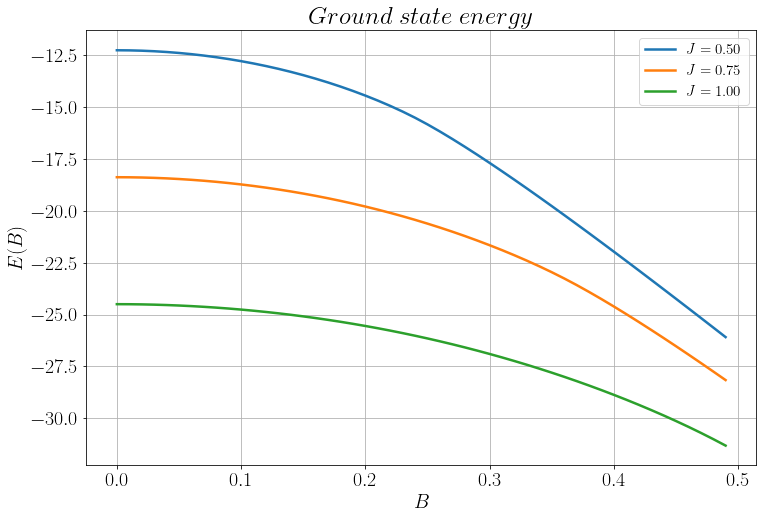

In [48]:
plt.figure(i, figsize=[12,8])
plt.title('$Ground\;state\;energy$')
plt.xlabel('$B$')
plt.ylabel('$E(B)$')

for i in range(len(J_values)):
    plt.plot(B_values,E_gr[i],linestyle='-',label='$J=%.2f$'%J_values[i])
plt.grid()
plt.legend()
plt.savefig('GS_Energy.jpg')

### Magnetic Susceptibility

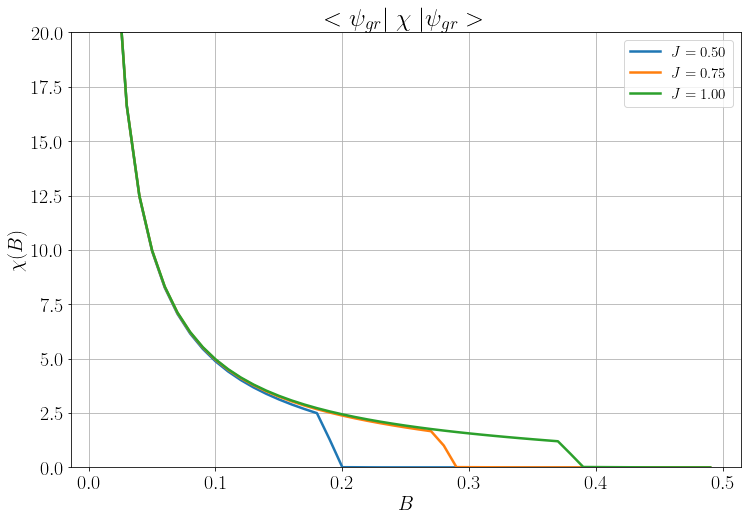

In [49]:
fig,ax=plt.subplots(1,1,figsize=[12,8])

ax.set_title('$< \psi_{gr}|\;\mathcal{\chi}\;|\psi_{gr} > $')
ax.set_xlabel('$B$')
ax.set_ylabel('$\chi(B)$')
ax.set_ylim(0,20)

for i in range(len(J_values)):
    ax.plot(B_values,X[i],linestyle='-',label='$J=%.2f$'%J_values[i])
    
ax.grid()
#ax.set_yscale('log')
ax.legend()
plt.savefig('GS_X.jpg')

# Appendix

# H_MPO

In [52]:
IM.H_MPO._W[0],IM.H_MPO._W[1],IM.H_MPO._W[2]

(<npc.Array shape=(2, 3, 2, 2) labels=['wL', 'wR', 'p', 'p*']>,
 <npc.Array shape=(3, 4, 2, 2) labels=['wL', 'wR', 'p', 'p*']>,
 <npc.Array shape=(4, 4, 2, 2) labels=['wL', 'wR', 'p', 'p*']>)

In [79]:
print(IM.H_MPO._W[5][i])

<npc.Array shape=(4, 2, 2) labels=['wR', 'p', 'p*']
charge=ChargeInfo([], [])
 -1 | +1 | -1 
0 []|0 []|0 []
1   |2   |2   
2   |    |    
3   |    |    
4   |    |    
[[[ 1.     0.   ]
  [ 0.     1.   ]]

 [[ 0.     0.   ]
  [ 0.     0.   ]]

 [[-0.5    0.   ]
  [ 0.     0.5  ]]

 [[-0.    -0.245]
  [-0.245 -0.   ]]]
>


W=npc.Array(...)

H_MPO=tenpy.network.mpo.MPO(sites,[W,W,W,...],...)

model.H_MPO=H_MPO

dmrg=DMRGEngine(psi,model,...)
dmrg.run()

# BONUS: iDMRG 

In [112]:
ising_params['bc_mps']='infinite'
ising_params['bc']='periodic'
ising_params['plot_lattice']=False
IM=IsingZZX(ising_params)

psi0=IM.initial_state(mode='Neel') 

In [113]:
print(psi0._B[0])

<npc.Array shape=(1, 2, 1) labels=['vL', 'p', 'vR']
charge=ChargeInfo([], [])
 +1 | +1 | -1 
0 []|0 []|0 []
1   |2   |1   
[[[1.]
  [0.]]]
>


In [116]:
dmrg_params = {
    'mixer': True,
    'min_sweeps':10,
    'max_sweeps':150,
    'chi_list':{0:40,20:60,50:80,100:100},
    'trunc_params': {'svd_min': 1.e-10},
    'max_hours':0.5,
    'max_E_err': 1.e-10
}


In [117]:
B_values=np.arange(0,5,0.1)
J_values=[1.0]

E_gr=[[] for i in J_values]
X=[[] for i in J_values]

''' Initial State'''
psi0=IM.initial_state(mode='Neel')


for j,J in enumerate(J_values):
    print('J=%.2f'%J)
    ising_params['J']=[0,J]
    psi_gr=psi0.copy()
    for i,B in enumerate(B_values):
        ising_params['B']=B
        IM=IsingZZX(ising_params)                

        '''GR. STATE'''

        eng=TwoSiteDMRGEngine(psi_gr,IM,DMRG_options) 
        E_run,psi_gr=eng.run()

        E_gr[j].append(E_run)
        X[j].append(np.sum(np.abs(psi_gr.expectation_value('Sz')))/psi_gr.L/B)
        print('    B: %.2f \t\t E: %.2f \t\t X: %.2f '%(B,E_gr[j][i],X[j][i]))
        print(psi_gr.expectation_value('Sz'))


J=1.00


C:\Users\Asus\AppData\Local\Temp\ipykernel_13056\2682996460.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  X[j].append(np.sum(np.abs(psi_gr.expectation_value('Sz')))/psi_gr.L/B)


    B: 0.00 		 E: -0.25 		 X: inf 
[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5]
    B: 0.10 		 E: -0.25 		 X: 4.97 
[-0.49886995 -0.49747655 -0.49747655 -0.4974556  -0.4974556  -0.49745514
 -0.49745514 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512
 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512
 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512
 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.49745512
 -0.49745512 -0.49745512 -0.49745512 -0.49745512 -0.497

final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=1.25e-09, calling psi.canonical_form()
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form

    B: 0.20 		 E: -0.26 		 X: 2.44 
[-0.4952299  -0.48960038 -0.48960038 -0.48925524 -0.48925524 -0.48922446
 -0.48922446 -0.48922123 -0.48922123 -0.48922085 -0.48922085 -0.48922081
 -0.48922081 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208  -0.4892208
 -0.4892208  -0.4892208  -

final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=3.41e-09, calling psi.canonical_form()
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi


    B: 0.30 		 E: -0.27 		 X: 1.57 
[-0.48810659 -0.47521632 -0.47521632 -0.47337134 -0.47337134 -0.47299392
 -0.47299392 -0.47290361 -0.47290361 -0.47288001 -0.47288001 -0.47287348
 -0.47287348 -0.47287161 -0.47287161 -0.47287105 -0.47287105 -0.47287088
 -0.47287088 -0.47287083 -0.47287083 -0.47287081 -0.47287081 -0.47287081
 -0.47287081 -0.47287081 -0.47287081 -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.4728708
 -0.4728708  -0.4728708  -0.4728708  -0.4728708  -0.47287079 -0.4728708
 -0.47287077 -0.4728708  -0.4728707  -0.47287081 -0.47287049 -0.47287081
 -0.47286989 -0.4728708

final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=2.82e-08, calling psi.canonical_form()
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi


    B: 0.40 		 E: -0.29 		 X: 1.09 
[-0.4744808  -0.45095751 -0.45095738 -0.44455744 -0.44455733 -0.44213834
 -0.44213827 -0.44108343 -0.44108339 -0.44058472 -0.4405847  -0.44033631
 -0.44033631 -0.44020797 -0.44020797 -0.44013984 -0.44013984 -0.4401029
 -0.4401029  -0.44008253 -0.44008253 -0.44007115 -0.44007115 -0.44006472
 -0.44006472 -0.44006105 -0.44006105 -0.44005893 -0.44005893 -0.44005771
 -0.44005771 -0.44005699 -0.44005699 -0.44005657 -0.44005656 -0.44005633
 -0.44005631 -0.44005618 -0.44005614 -0.44005609 -0.44005603 -0.44005604
 -0.44005593 -0.44005601 -0.44005583 -0.44005599 -0.44005569 -0.44005598
 -0.44005549 -0.44005598 -0.44005519 -0.44005598 -0.44005471 -0.44005598
 -0.44005395 -0.440056   -0.44005272 -0.44005601 -0.44005077 -0.44005605
 -0.44004763 -0.4400561  -0.44004259 -0.44005619 -0.44003449 -0.44005634
 -0.44002145 -0.44005659 -0.44000042 -0.44005701 -0.43996646 -0.44005773
 -0.43991147 -0.44005896 -0.43982222 -0.44006108 -0.43967693 -0.44006476
 -0.43943957 -0.

KeyboardInterrupt: 

In [ ]:
plt.figure(i, figsize=[12,8])
plt.title('$Ground\;state\;energy$')
plt.xlabel('$B$')
plt.ylabel('$E(B)$')

for i in range(len(J_values)):
    plt.plot(B_values,E_gr[i],linestyle='-',label='$J=%.2f$'%J_values[i])
plt.grid()
plt.legend()
plt.savefig('GS_Energy.jpg')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=[12,8])

ax.set_title('$< \psi_{gr}|\;\mathcal{\chi}\;|\psi_{gr} > $')
ax.set_xlabel('$B$')
ax.set_ylabel('$\chi(B)$')
ax.set_ylim(0,20)

for i in range(len(J_values)):
    ax.plot(B_values,X[i],linestyle='-',label='$J=%.2f$'%J_values[i])
    
ax.grid()
#ax.set_yscale('log')
ax.legend()
plt.savefig('GS_X.jpg')